# GradCAM - Gradient Class Activation Map

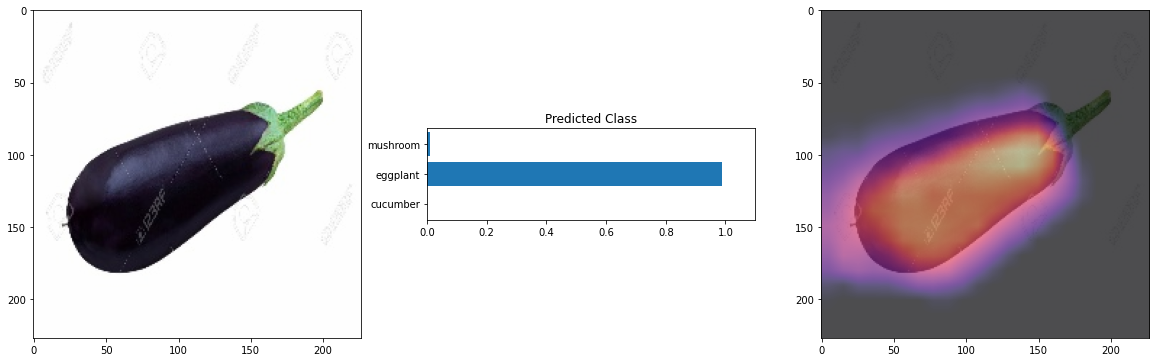

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 6.94 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vr63x36z
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vr63x36z
     |████████████████████████████████| 48.3 MB 149 kB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=114151 sha256=321dd7adf0143f7a6f49fef3aa0eb4e6bc91a6502a8a2661522f3d845f3f03c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-hgs86re0/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Atte

# Imports

In [2]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [30]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cpu' #'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),

])

# Load Image Dataset 

In [8]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


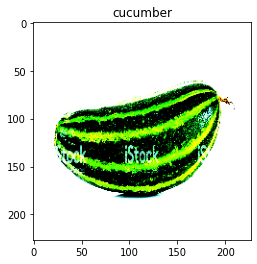

In [14]:
image, label = validset[22] # trainset[0] # (c, h, w) -> (h, w, c)

class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [12]:
print(f"No. of examples in the trainset: {len(trainset)}")
print(f"No. of examples in the validset: {len(validset)}")

No. of examples in the trainset: 148
No. of examples in the validset: 38


# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE) 


In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [17]:
for images, labels in trainloader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model 

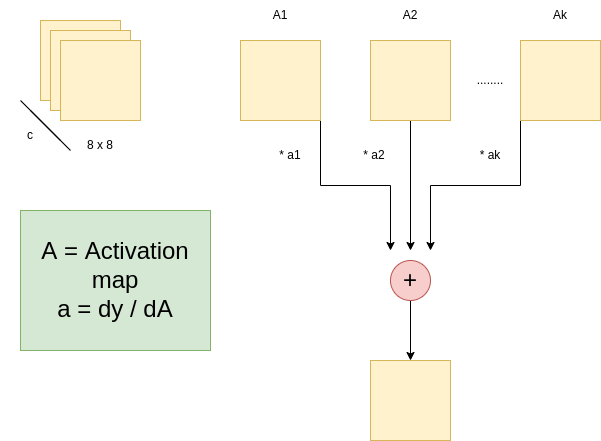

In [31]:
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size= (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size= (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size= (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= (5,5), padding = 1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):
        x = self.feature_extractor(images) #activation maps

        h = x.register_hook(self.activations_hook)

        x = self.maxpool(x)
        x = self.classifier(x)
        return x

    def get_activation_gradients(self): #a1,a2,a3,...,ak
        return self.gradient

    def get_activation(self, x): #A1,A2,A3,...,AK
        return self.feature_extractor(x) # 64 * 8 * 8

In [32]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [33]:
def train_fn(dataloader, model, optimizer, criterion):

    model.train()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/ len(dataloader)

In [36]:
from albumentations.augmentations.transforms import ImageCompression
def eval_fn(dataloader, model, criterion):

    model.eval()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()

    return total_loss/ len(dataloader)

# Training Loop

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [38]:
best_valid_loss = np.Inf 

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader, model, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCH: {i + 1} TRAIN LOSSL: {train_loss} VALID_LOSS: {valid_loss}")

100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 1 TRAIN LOSSL: 1.1395012140274048 VALID_LOSS: 0.8101048866907755


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 2 TRAIN LOSSL: 0.5633862718939782 VALID_LOSS: 0.38285908102989197


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


EPOCH: 3 TRAIN LOSSL: 0.22415794171392917 VALID_LOSS: 0.5874916315078735


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


EPOCH: 4 TRAIN LOSSL: 0.3253845199942589 VALID_LOSS: 0.5576071093479792


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 5 TRAIN LOSSL: 0.1274854863062501 VALID_LOSS: 0.2647192208096385


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH: 6 TRAIN LOSSL: 0.10753148584626615 VALID_LOSS: 0.008980765007436275


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


EPOCH: 7 TRAIN LOSSL: 0.1494137522240635 VALID_LOSS: 0.27080701041268185


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


EPOCH: 8 TRAIN LOSSL: 0.11873076477786526 VALID_LOSS: 0.6322143425544103


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


EPOCH: 9 TRAIN LOSSL: 0.4139532780274749 VALID_LOSS: 0.3506947010755539


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


EPOCH: 10 TRAIN LOSSL: 0.23259671963751316 VALID_LOSS: 0.30455416440963745


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


EPOCH: 11 TRAIN LOSSL: 0.14097913291770964 VALID_LOSS: 0.44693293670813244


100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


EPOCH: 12 TRAIN LOSSL: 0.29977543111890553 VALID_LOSS: 0.2700911263624827


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


EPOCH: 13 TRAIN LOSSL: 0.1721394654829055 VALID_LOSS: 0.42268051703770954


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


EPOCH: 14 TRAIN LOSSL: 0.13504542720038443 VALID_LOSS: 0.12408683231721322


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


EPOCH: 15 TRAIN LOSSL: 0.24143948857672512 VALID_LOSS: 0.23467512925465903


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


EPOCH: 16 TRAIN LOSSL: 0.0734710198827088 VALID_LOSS: 0.075028071179986


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


EPOCH: 17 TRAIN LOSSL: 0.10063443920516875 VALID_LOSS: 0.4984622498353322


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


EPOCH: 18 TRAIN LOSSL: 0.06720761839533225 VALID_LOSS: 0.018647164339199662


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


EPOCH: 19 TRAIN LOSSL: 0.1092128574149683 VALID_LOSS: 0.12493776250630617


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

EPOCH: 20 TRAIN LOSSL: 0.11503717126324772 VALID_LOSS: 0.1019630494217078


# Get GradCAM

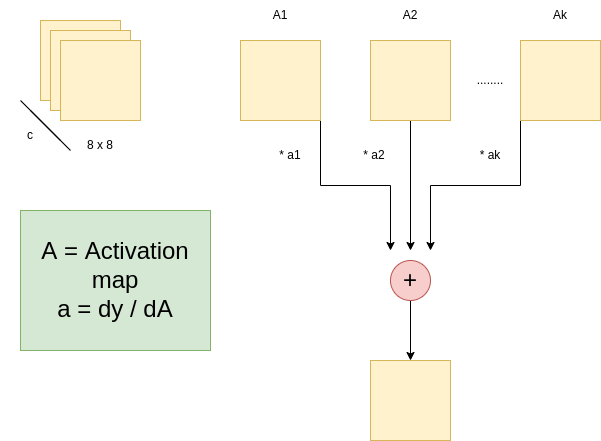

In [42]:
def get_gradcam(model, image, label, size):
    label.backward() 
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) #a1, a2, a3
    activations = model.get_activation(image).detach() #A1, A2, A3
    
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))

    return heatmap


In [43]:
# cucumber - 0, eggplant - 1, mushroom - 2

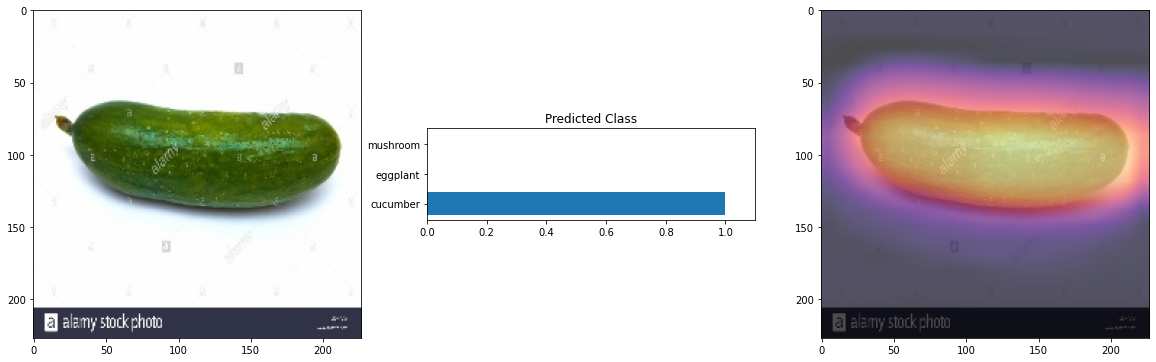

In [48]:
image, label = validset[8]

denorm_image = image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)